In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.fftpack import fft
import pywt
import matplotlib.pyplot as plt

# ------------------- 参数配置 ------------------- #
WINDOW_SIZE = 60  # 60秒窗口
IMPORTANT_FEATURES = ['PSHBOUTTE.AV', 'PSHAOUTTE.AV', 'LAE72AA101ZZ.AV', 'LAE71AA101ZZ.AV', 'LAE74AA101ZZ.AV']
ALL_FEATURES = [
    'LAE71AA101ZZ.AV', 'A1SPRFLOW.AV', 'LAE72AA101ZZ.AV', 'B1SPRFLOW.AV',
    'LAE73AA101ZZ.AV', 'A2SPRFLOW.AV', 'LAE74AA101ZZ.AV', 'B2SPRFLOW.AV',
    'PSHAOUTTE.AV', 'PSHBOUTTE.AV'
]
# TARGET = 'SHAOUTTE.AV'
TARGET = 'SHBOUTTE.AV'
# ------------------- 特征提取函数 ------------------- #
def extract_features_for_window(window: pd.DataFrame, important_features: list):
    feats = []
    for col in window.columns:
        x = window[col].values
        feats.extend([np.mean(x), np.std(x), np.min(x), np.max(x)])

        if col in important_features:
            fft_vals = np.abs(fft(x))[:len(x)//2]
            feats.extend(np.sort(fft_vals)[-3:])

            coeffs = pywt.wavedec(x, wavelet='db4', level=3)
            for c in coeffs:
                feats.extend([np.mean(c), np.std(c)])
    return feats

# ------------------- 数据加载与处理 ------------------- #
data = pd.read_csv("../datasets/train.csv")
# data = pd.read_csv("../datasets/processed/2024-01_processed.csv")
testdata = pd.read_csv("../datasets/test.csv")

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
data[ALL_FEATURES] = scaler_X.fit_transform(data[ALL_FEATURES])
data[TARGET] = scaler_y.fit_transform(data[[TARGET]])



X_feat, y_feat = [], []
for i in range(0, len(data) - WINDOW_SIZE, WINDOW_SIZE):
    window = data.iloc[i:i+WINDOW_SIZE]
    feat = extract_features_for_window(window[ALL_FEATURES], IMPORTANT_FEATURES)
    target = data.iloc[i + WINDOW_SIZE - 1][TARGET]  # 取窗口末值作为目标
    X_feat.append(feat)
    y_feat.append(target)

X = np.array(X_feat)
y = np.array(y_feat)

testdata[ALL_FEATURES] = scaler_X.fit_transform(testdata[ALL_FEATURES])
testdata[TARGET] = scaler_y.fit_transform(testdata[[TARGET]])



X_test_feat, y_test_feat = [], []
for i in range(0, len(testdata) - WINDOW_SIZE, WINDOW_SIZE):
    window = testdata.iloc[i:i+WINDOW_SIZE]
    feat = extract_features_for_window(window[ALL_FEATURES], IMPORTANT_FEATURES)
    target = testdata.iloc[i + WINDOW_SIZE - 1][TARGET]  # 取窗口末值作为目标
    X_test_feat.append(feat)
    y_test_feat.append(target)

X_test = np.array(X_test_feat)
y_test = np.array(y_test_feat)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.model_selection import GridSearchCV
# 搜索最佳 n_estimators（树的数量）
param_grid_n_estimators = {
    'n_estimators': [10,20,30,40,50]
}

grid_search_n = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid_n_estimators,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)
grid_search_n.fit(X_train, y_train)
print("Best n_estimators:", grid_search_n.best_params_)

In [ ]:
# 基于最佳 n_estimators 继续调 max_depth
param_grid_depth = {
    'max_depth': [5, 10, 15, 20]
}

grid_search_depth = GridSearchCV(
    RandomForestRegressor(n_estimators=grid_search_n.best_params_['n_estimators'], random_state=42),
    param_grid_depth,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)
grid_search_depth.fit(X_train, y_train)
print("Best max_depth:", grid_search_depth.best_params_)

In [ ]:
param_grid_split = {
    'min_samples_split': [2, 5, 10]
}

grid_search_split = GridSearchCV(
    RandomForestRegressor(
        n_estimators=grid_search_n.best_params_['n_estimators'],
        max_depth=grid_search_depth.best_params_['max_depth'],
        random_state=42
    ),
    param_grid_split,
    cv=2,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)
grid_search_split.fit(X_train, y_train)
print("Best min_samples_split:", grid_search_split.best_params_)

In [ ]:
param_grid_leaf = {
    'min_samples_leaf': [1, 2, 4]
}

grid_search_leaf = GridSearchCV(
    RandomForestRegressor(
        n_estimators=grid_search_n.best_params_['n_estimators'],
        max_depth=grid_search_depth.best_params_['max_depth'],
        min_samples_split=grid_search_split.best_params_['min_samples_split'],
        random_state=42
    ),
    param_grid_leaf,
    cv=2,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)
grid_search_leaf.fit(X_train, y_train)
print("Best min_samples_leaf:", grid_search_leaf.best_params_)

In [9]:
# 用最佳参数训练最终模型
best_model = RandomForestRegressor(random_state=42,n_estimators=6,max_depth=20,min_samples_split=10,min_samples_leaf=1)
best_model.fit(X_train, y_train)


RandomForestRegressor(max_depth=20, min_samples_split=10, n_estimators=6,
                      random_state=42)

In [ ]:
import joblib

# 保存训练好的模型
joblib.dump(best_model, 'B_Timeseries.pkl')

# 同时保存特征和目标的 Scaler
joblib.dump(scaler_X, 'B_Timescaler_X.pkl')
joblib.dump(scaler_y, 'B_Timescaler_y.pkl')

['A_Timescaler_y.pkl']

In [ ]:
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 加载模型和 Scaler
best_model = joblib.load("B_Timeseries.pkl")
scaler_X = joblib.load('B_Timescaler_X.pkl')
scaler_y = joblib.load("B_Timescaler_y.pkl")




Test MSE: 85.9464
R2 Score: 0.9978


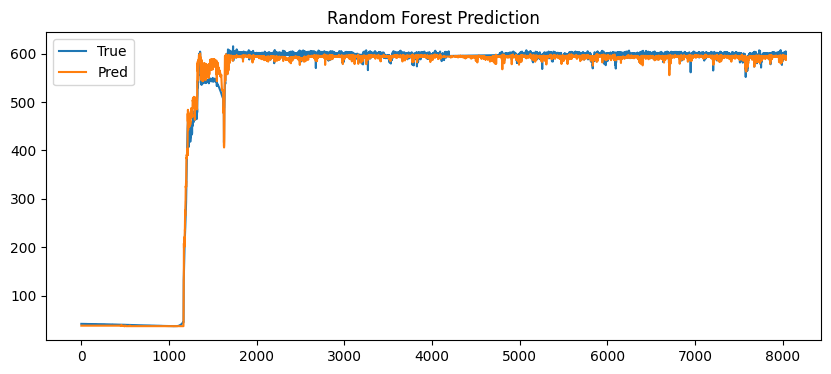

In [10]:
y_pred = best_model.predict(X_test)
# 还原预测结果
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# 评估
mse = mean_squared_error(y_test_inv, y_pred_inv)
print(f"Test MSE: {mse:.4f}")
print(f"R2 Score: {r2_score(y_test_inv, y_pred_inv):.4f}")

plt.figure(figsize=(10,4))
plt.plot(y_test_inv, label='True')
plt.plot(y_pred_inv, label='Pred')
plt.title('Random Forest Prediction')
plt.legend()
plt.show()


In [11]:
explainer1 = shap.Explainer(best_model, X_train)
shap_values1 = explainer1(X_train, check_additivity=False)

100%|===================| 34885/34992 [01:43<00:00]        

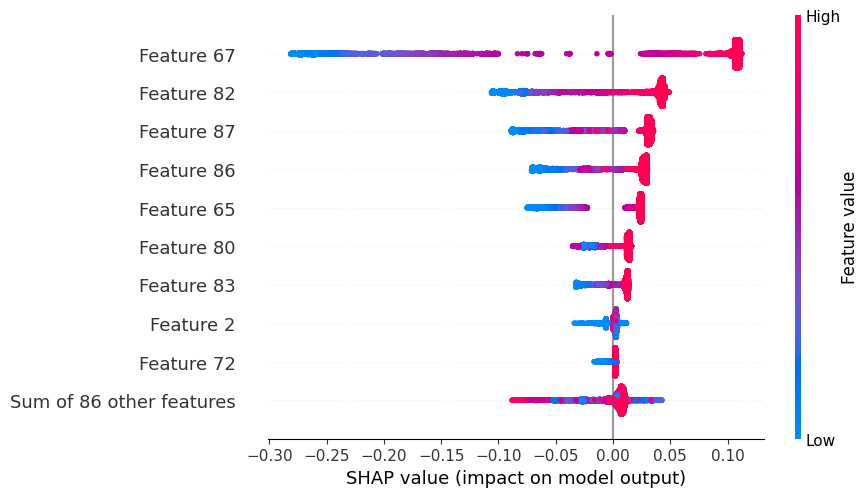

In [12]:
shap.plots.beeswarm(shap_values1)

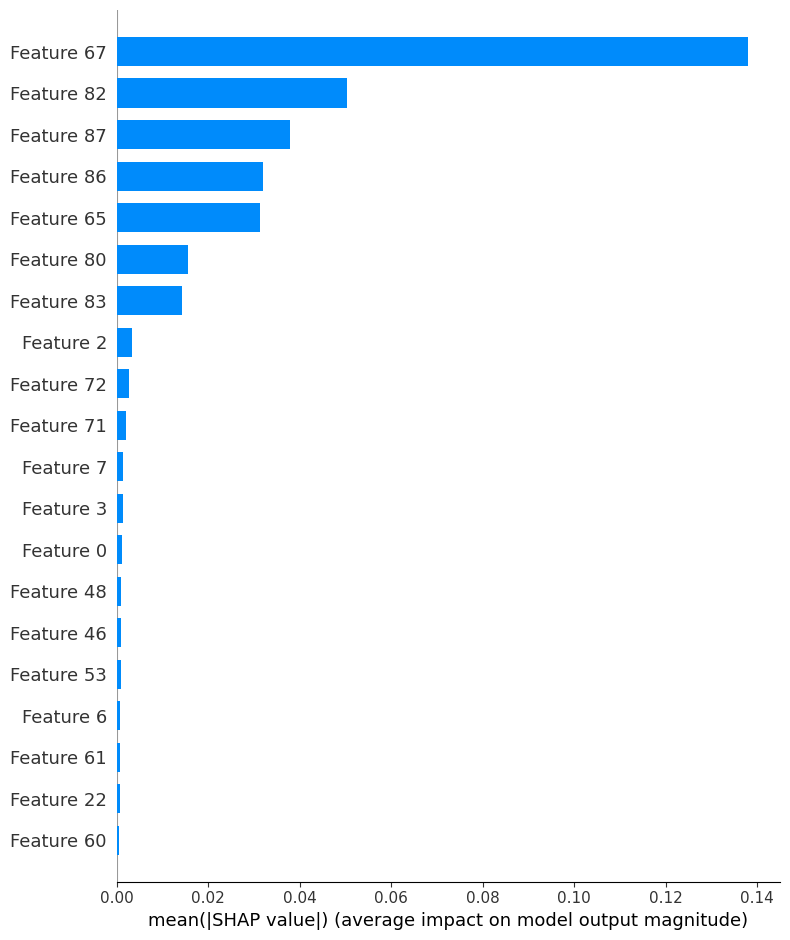

In [13]:
shap.summary_plot(
    shap_values1,         # 第一个目标的 shap 值
    X_train,                  # 原始未缩放的特征值
    plot_type="bar",
    show=True
)
